In [172]:
import pandas as pd
import numpy as np

import sklearn as sklearn
# from tensorflow.keras.layers import Dense, Activation, LSTM
# from tensorflow.keras.models import Sequential, Model


from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import random
import pandas_datareader as pdr
import xgboost as xgb

In [173]:
pd.set_option('display.max_columns', None)
file_data = pd.read_csv('/Users/arjunarasappan/Documents/Projects/WAF Technical/final_data.csv')

In [174]:
final_data = file_data.drop(['Unnamed: 0'], axis = 1)
final_data

,Refact_MONTH,Refact_DAY_OF_MONTH,Refact_DAY_OF_WEEK,Refact_OP_UNIQUE_CARRIER,Refact_ORIGIN,Refact_DEST,CRS_DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,PRCP,SNOW,SNWD,TMIN,TMAX,TAVG,AWND,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS
0,12.182613,16.534128,15.705022,11.020963,16.749210,12.278054,1226,3.0,0.0,1351,85.0,337.0,0.00,0.0,0.0,46.0,61.0,53.0,7.61,13989.0,84142.0,1146.0,1908862.0,12460183.0,0.000144,0.000149
1,10.910723,11.293329,14.827057,12.396002,13.172729,14.101160,950,6.0,0.0,1310,140.0,919.0,0.42,0.0,0.0,45.0,50.0,50.0,15.88,6261.0,115051.0,5727.0,673221.0,13382999.0,0.000062,0.000099
2,15.655559,16.030375,14.827057,14.172671,12.794254,17.529299,1510,0.0,0.0,2050,220.0,1514.0,0.00,0.0,0.0,44.0,66.0,54.0,3.80,11500.0,70199.0,1059.0,1903352.0,11744595.0,0.000098,0.000177
3,10.910723,14.653492,12.625661,19.419245,15.939545,14.306413,2100,0.0,0.0,27,147.0,862.0,0.22,6.6,5.9,7.0,18.0,15.0,12.30,22355.0,12581.0,2616.0,2743323.0,1857122.0,0.000116,0.000007
4,15.655559,17.929581,12.625661,11.020963,9.941939,12.713454,1528,14.0,0.0,1900,152.0,991.0,0.00,0.0,0.0,22.0,27.0,26.0,10.74,8345.0,67273.0,3086.0,1065782.0,12460183.0,0.000144,0.000149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620109,10.059551,14.653492,14.827057,11.020963,13.306095,16.014940,1229,0.0,0.0,1527,178.0,1127.0,0.00,0.0,0.0,32.0,38.0,35.0,4.92,13199.0,79989.0,4894.0,1486066.0,12460183.0,0.000144,0.000149
620110,15.872458,12.318166,15.230647,16.335918,10.591371,17.529299,2340,0.0,0.0,507,207.0,1498.0,0.00,0.0,0.0,56.0,79.0,67.0,4.25,1162.0,55706.0,88.0,162026.0,8501631.0,0.000254,0.000229
620111,17.614274,15.391774,15.230647,11.020963,16.956970,18.579174,1558,332.0,1.0,1730,92.0,187.0,0.85,0.0,0.0,67.0,84.0,81.0,11.41,12603.0,90457.0,1635.0,1472200.0,12460183.0,0.000144,0.000149
620112,10.059551,14.052764,15.705022,12.396002,13.172729,14.101160,1605,0.0,0.0,1920,135.0,919.0,0.64,0.0,0.0,43.0,71.0,59.0,11.41,5954.0,108130.0,5542.0,673221.0,13382999.0,0.000062,0.000099


# Feature Engineering
Now that we've cleaned, pre-processed, and visualized our data, we can now split the data into test and train samples. With a dataset of 600k entries, we can split the data into two sets: a test set and a train set. If we didn;t have anough data to properly train and test a model, we could use k-fold cross validation to asses model performances when trained on different portions of the dataset and tested on the sections it was not trained on. But for our purpose we will use a 80% training set size and a 20% test set size to finally asses our models. 


Before training our model, we'll use clustering to engineer features for the models to take in as inputs. Clustering is often used before model training to engineer features that are *NOT* linear combinations of the original variables, preventing multicollinearity. Multicollinearity can be problematic as it occurs when two predictor variables are highly correlated, and can undermine signifigance of the variables.  

We'll be using the KMeans clusting algorithm to cluster our data. KMeans is an unsupervised clustering algorithm, meaning it does not require labeled data to run. KMeans arbitrarily chooses centroid positions, where the number of centroids is provided, and chooses a metric—often Euclidian distance—to asses the density of the data around the centroid. The centroid represents the 'center' of a cluster, so a tighter cluster would have a lower distance aggregate. The training algorithm will then move the centroids, with gradient descent, to reduce the distance metric such that it converges on a final state where the centroids are optimally placed. Since gradeint descent tends to get caught up on local minima, the KMeans algo will run generate these clusters a number of times with different starting centroid locations and choose the optimal clustering of all the runs.


In [175]:
from sklearn.model_selection import train_test_split

y_data = final_data[['DEP_DELAY_NEW', 'DEP_DEL15']]
x_data = final_data.drop(['DEP_DELAY_NEW', 'DEP_DEL15'], axis = 1)


In [176]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=y_data['DEP_DEL15'])
y_train_regres = y_train['DEP_DELAY_NEW']
y_train_class = y_train['DEP_DEL15']

y_test_regres = y_test['DEP_DELAY_NEW']
y_test_class = y_test['DEP_DEL15']


/Users/arjunarasappan/anaconda3/envs/python-tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/arjunarasappan/anaconda3/envs/python-tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/arjunarasappan/anaconda3/envs/python-tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/arjunarasappan/anaconda3/envs/python-tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

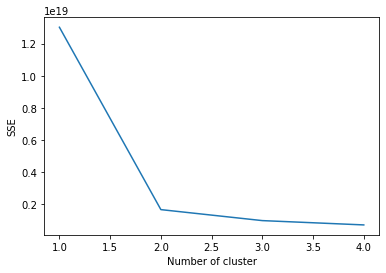

In [177]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

sse = {}
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k, max_iter=300).fit(x_train)
    x_train["KMeans"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

From the KMeans elbow curve above we see that the optimal number of clusters is 2. 

In [178]:
k = 2
kmeans = KMeans(n_clusters=2, max_iter=300).fit(x_train)
x_train["KMeans"] = kmeans.labels_
kmeans_test = KMeans(n_clusters=2, max_iter=300).fit(x_test)
x_test["KMeans"] = kmeans_test.labels_

/Users/arjunarasappan/anaconda3/envs/python-tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/arjunarasappan/anaconda3/envs/python-tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.0    235431
1.0     54938
Name: DEP_DEL15, dtype: int64


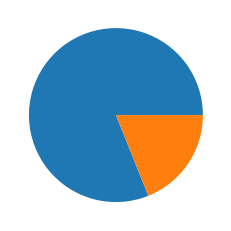

0.0    165666
1.0     40056
Name: DEP_DEL15, dtype: int64


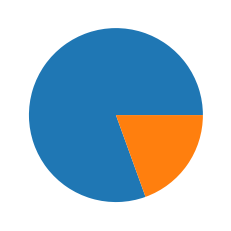

In [179]:
df = pd.concat([x_train['KMeans'], y_train['DEP_DEL15']], axis = 1)
clusters = []
for i in range(k):
    cl = df[df['KMeans'] == i]
    clusters.append(cl)

for cl in clusters:
    
    s = cl['DEP_DEL15'].value_counts()
    print(s)
    fig = plt.figure()
    plt.pie(s)
    plt.show()


In the above code, we've applied the KMeans algorith with 2 clusters, though each cluster on its own does not provide enough information to determine whether an entry is going to be delayed or not. When running the algorightm with 3 clusters, the third cluster was not assigned to any data points, indicating 2 clusters is sufficent. We'll cluster all of the training set and allow for our classification models to determine if the cluster of an entry provides any insights in conjunction with the the other predictors. 

# Dimensionality Reduction


We can reduce dimensions of our data without losing features that may help classify and predict delay times. PCA normalizes the data set, and then applies singular value decomposition which applies a change of basis transformation to reduce multicollinearity in our data. Since we transform all our training and testing inputs to new vector subspaces that are fed into the model, we lose our ability to interpret importance and the effects of our predictors—one of the main drawbacks.

At first when I ran my linear logistic regression, the model could not converge within the allotted iterations. So I looked to PCA to reduce the multicollineaity of the data, which allowed more stable and accurate linear models.  

In [180]:
x_train

,Refact_MONTH,Refact_DAY_OF_MONTH,Refact_DAY_OF_WEEK,Refact_OP_UNIQUE_CARRIER,Refact_ORIGIN,Refact_DEST,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,PRCP,SNOW,SNWD,TMIN,TMAX,TAVG,AWND,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,KMeans
300934,15.655559,12.318166,12.625661,12.396002,16.358988,13.788832,2015,2255,160.0,1072.0,0.11,0.0,0.0,59.0,74.0,66.0,8.50,10780.0,94922.0,3110.0,1823051.0,13382999.0,0.000062,0.000099,0
469396,12.182613,14.052764,15.705022,26.938606,14.964796,13.372549,1535,1625,50.0,100.0,0.00,0.0,0.0,21.0,46.0,33.0,4.92,2139.0,12510.0,188.0,182555.0,473794.0,0.000000,0.000200,1
25303,15.872458,11.293329,14.202322,13.520431,14.964796,20.418260,1555,1722,87.0,292.0,0.00,0.0,0.0,63.0,81.0,72.0,9.62,2134.0,28893.0,187.0,182555.0,1204766.0,0.000348,0.000107,1
456317,13.769387,15.391774,15.230647,13.520431,17.522244,15.377555,1259,1508,69.0,264.0,0.02,0.0,0.0,58.0,80.0,68.0,13.20,26142.0,25138.0,5184.0,3103410.0,1204766.0,0.000348,0.000107,1
284555,10.070644,17.929581,15.705022,11.020963,10.975749,10.524121,1140,1424,224.0,1448.0,0.04,0.0,0.0,53.0,70.0,60.0,3.58,12203.0,81338.0,2621.0,1960746.0,12460183.0,0.000144,0.000149,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552483,17.614274,12.041985,12.801698,13.510003,14.590042,11.896944,1540,1726,106.0,405.0,0.00,0.0,0.0,62.0,90.0,77.0,3.80,11201.0,26909.0,2549.0,955406.0,1529740.0,0.000001,0.000124,1
414267,15.055998,13.310648,12.801698,12.396002,14.449858,11.020468,630,730,60.0,239.0,0.03,0.0,0.0,63.0,78.0,69.0,11.41,4946.0,113248.0,4559.0,589072.0,13382999.0,0.000062,0.000099,0
608121,10.910723,13.703356,15.705022,12.396002,13.714073,14.816808,500,815,135.0,882.0,0.94,0.0,0.0,62.0,71.0,66.0,9.62,6015.0,115051.0,3486.0,642980.0,13382999.0,0.000062,0.000099,0
375063,13.769387,14.343641,14.202322,11.020963,10.804751,19.123447,1630,1801,91.0,432.0,1.29,0.0,0.0,53.0,77.0,73.0,16.33,32678.0,81803.0,20473.0,4365661.0,12460183.0,0.000144,0.000149,0


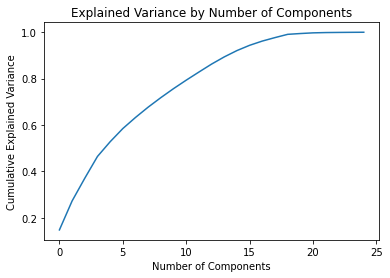

In [181]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

doPCA = True
if doPCA:
    pca = PCA()
    x_pca = pca.fit_transform(x_train_scaled)

    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Number of Components')
    plt.show()

Above we can see the graph of cumulartive explanied variance asa function of the number of components. Usually we want our data to have 95% or higher cumulative explained variance when reducing dimentionality. 

In [182]:
x_test_scaled = scaler.fit_transform(x_test)

pca_transformed = {}
transformed_x_train = pd.DataFrame(pca.transform(x_train_scaled))
transformed_x_test = pd.DataFrame(pca.transform(x_test_scaled))

for i in range(5, 29):
    pca_transformed[i] = [transformed_x_train.iloc[:, :i], transformed_x_test.iloc[:, :i]]

transformed_x_train.var()

0     3.696412
1     3.121012
2     2.450290
3     2.345416
4     1.586012
5     1.421811
6     1.196773
7     1.112473
8     1.025907
9     0.968722
10    0.911564
11    0.874625
12    0.858279
13    0.774770
14    0.681505
15    0.568212
16    0.456102
17    0.374387
18    0.350173
19    0.086838
20    0.072632
21    0.031812
22    0.014266
23    0.011411
24    0.008647
dtype: float64

# Model Building

There are a few classification and regression models that we will apply on the dataset: a linear logistic regession, decision tree, gradient boosted decision tree classifier and regressor, and a linear regressor. 

### Linear logistic regression

Sklearn impliments a linear logistic regression model, which is a type of binary classifier. Similar to linear regression, sklearn's linear logistic regression model fits and finds a linear equation of all predictor variables and produces a y-hat. It then plugs this y-hat value which ranges from (-infinity, +infinity) into a sigmoid function which spits out a value between zero and one. Based on how high this value is and whether it is above a threshold value (0.5 for example), the linear logistic regresson model decides whether to classify the entry as a zero or one. In the training process the logistic regression finds coefficients to the predictor variables to optimize its classfication accuracies.

The drawback to this model is it can only classify datasets with linear decision boundaries, as each predictor variable is assigned a linear coefficient. Thus it is unable to capture more complex relationships and patterns between data in the training dataset. It must decide whether a predictor increases, decreases, or has no effect on the liklehood of an entry being in a class. The advantages of this model is that its especially efficient to train and deploy when classifying datasets with linear decision boundaries. 

### Linear regression

Similar to the linear logistic regression except the predicted y-hat value is directly returned as the predicted delay time rather than plugging into the sigmoid equation. 

### Decision trees
Decision trees are one of the simplest classifiers, but as opposed to the linear logistic regression, they're able to capture complex, non-linear relationships between predictor variables and between classes in the data set. The algorithm to fit a decision tree is fairly straighforward. First an homogeneity metric is chosen to asses the homegeneity of a group of data points—the more similar they are in their class assigments, the higher the homogeneity. The decision tree training algorithm iterativley finds a splitting value among a predictor variable that maximizes the homogeneity of the the two groups of data it creates from the split. This splitting action is iterativley done to groups of data that result from previous splits until all groups of data are fairly homogeonous. Now since all groups of data are homogenous after all the iterative splits, we call the nodes which have not split 'leaves'. These leaves are assigned a class, and all entries that fall into these leaves use the leaf's class to predict the class for that entry. Through iterative splitting to homogenize groups of data, the decicon tree eventually ends up with leaves that are fairly homegenous. The splitting paths it took to produce the homogenous groups form a tree—this tree is able to capture all linear and non-linear relationships between preductor variables that pertain to class assignment. 

### Gradient Boosting with decision trees
Gradient boosting is a type of boosted ensemble method, which sequentially trains models such that the newest model is trained to correct the errors of the previous models. The XGBoost library applies the gradient boosting method on decision trees, where trees are iterativley built and trained to reduce the residuals of the prevously trained model. In this process, 'weak' learners are built sequentially where the newest model is trained to correct the losses of the previous model through weighting. The final classification is then a weighted vote of all the models. Gradient boosting can be applied on deicision trees for regression where a weighted sum is used for the final output, and each model is trained to reduce the previous models' residual. 

The gradient part of gradeint boosting comes from the use of stochastic gradient descent to minimize a loss function that aims to capture how innacturate a model is. 


In [183]:
classifiers = {}
regressors = {}

# Linear Logistic Regression

In [217]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import RFE

def log_reg_classification(x_train, x_test, y_train, y_test, balanced = False):

    model = LogisticRegression(multi_class='multinomial')
    if balanced:
        model = LogisticRegression(multi_class='multinomial', class_weight='balanced')
        
    log_reg = model.fit(x_train, y_train)
    y_pred = log_reg.predict(x_test)
    
    classifiers['Log Reg'] = log_reg
    
    print("Classification Accuracy with {} cols: {}".format(len(x_test.columns), accuracy_score(y_test, y_pred)))



    cnf_matrix = confusion_matrix(y_test, y_pred)

    class_names=[0,1] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="RdYlBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Log Reg Confusion Matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print("F1 Score: {}".format(f1_score(y_test, y_pred)))

    

# Decion Tree Classifier

In [216]:
from sklearn import tree

def decision_tree_classification(x_train, x_test, y_train, y_test, plot_tree = False, depth = 5, getImportances = False):
    decision_tree = tree.DecisionTreeClassifier()
    decision_tree.fit(x_train, y_train)
    y_pred = decision_tree.predict(x_test)
    
    classifiers['Decision Tree'] = decision_tree

    print("Classification Accuracy with {} cols: {}".format(len(x_test.columns), accuracy_score(y_test, y_pred)))
    
    cnf_matrix = confusion_matrix(y_test, y_pred)

    class_names=[0,1] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="RdYlBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Decision Tree Confusion Matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print("F1 Score: {}".format(f1_score(y_test, y_pred)))

    
    if plot_tree:
        tree.plot_tree(decision_tree, max_depth= depth)
        plt.show()
        
    


# Gradient Boosted Decison Tree Classifier

In [215]:

def gradient_boosted_classification(x_train, x_test, y_train, y_test, ):
    XGB_classifier = xgb.XGBClassifier()
    XGB_classifier.fit(x_train, y_train)

    classifiers['XGB Classifier'] = XGB_classifier
    
    y_pred = XGB_classifier.predict(x_test)
     
    print("Classification Accuracy with {} cols: {}".format(len(x_test.columns), accuracy_score(y_test, y_pred)))
    
    cnf_matrix = confusion_matrix(y_test, y_pred)

    class_names=[0,1] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="RdYlBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('XGB Tree Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print("F1 Score: {}".format(f1_score(y_test, y_pred)))



# Linear Regressor

In [227]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error



def linear_regression(x_train, x_test, y_train, y_test):

    model = LinearRegression()
        
    lin_reg = model.fit(x_train, y_train)
    y_pred = lin_reg.predict(x_test)
    regressors['Lin Reg'] = lin_reg

    
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print("MSE with {} cols: {}".format(len(x_train.columns), mse))
    print("MAE with {} cols: {}".format(len(x_train.columns), mae))
    print("r^2 with {} cols: {}".format(len(x_test.columns), r_squared))
    
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='k', linestyles='dashed')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Linear Regression: Residuals vs. Predicted Values")
    plt.show()
    
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Linear Regression: Actual vs. Predicted Values")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.show()

    return (r_squared, mse, mae)


    

# Gradient Boosted Decison Tree Regressor

In [226]:
from sklearn.metrics import mean_squared_error, r2_score

def gradient_boosted_regression(x_train, x_test, y_train, y_test, ):
    
    XGB_regressor = xgb.XGBRegressor()
    XGB_regressor.fit(x_train, y_train)
    y_pred = XGB_regressor.predict(x_test)
    
    regressors['XGB Regressor'] = XGB_regressor
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("MSE with {} cols: {}".format(len(x_train.columns), mse))
    print("MAE with {} cols: {}".format(len(x_train.columns), mae))
    print("r^2 with {} cols: {}".format(len(x_test.columns), r2))
    
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='k', linestyles='dashed')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("XGB Regression: Residuals vs. Predicted Values")
    plt.show()
    
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("XGB Regression: Actual vs. Predicted Values")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.show()
    
    return (r2, mse, mae)

# Testing Linear Logistic Regression

Classification Accuracy with 5 cols: 0.580360094498601
F1 Score: 0.3563168635211181
Classification Accuracy with 10 cols: 0.6153536037670432
F1 Score: 0.37781226768223497
Classification Accuracy with 15 cols: 0.6256258919716504
F1 Score: 0.3874780681503371
Classification Accuracy with 20 cols: 0.6256017029099441
F1 Score: 0.3914764238723035
Classification Accuracy with 25 cols: 0.6261257992469139
F1 Score: 0.39235214719102596


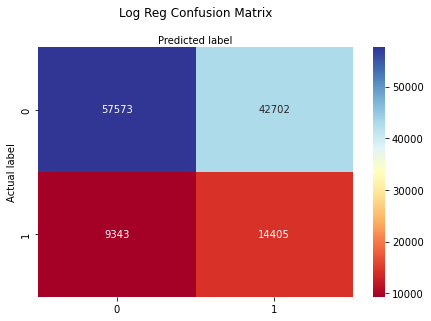

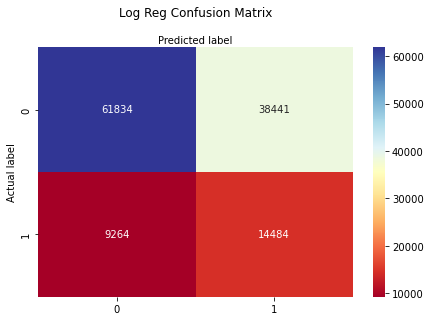

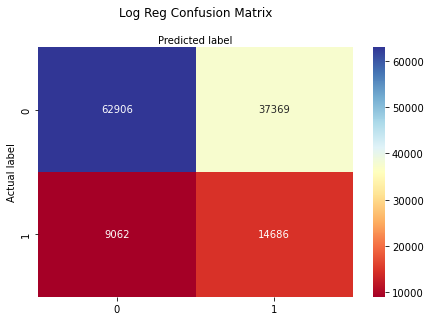

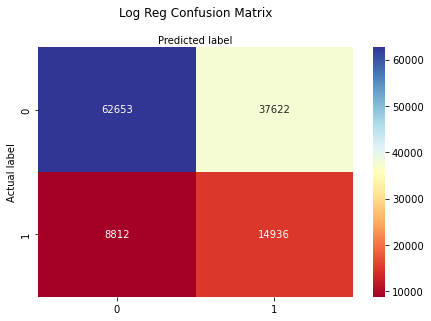

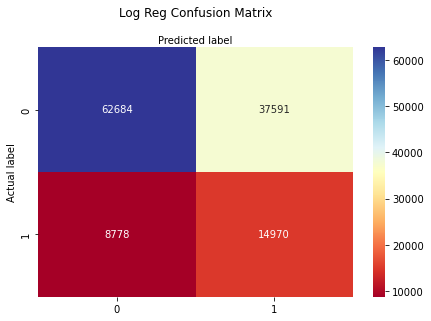

In [218]:
for i in range (0, 5):
    k = 5 + i*5
    cut_x_train = pca_transformed.get(k)[0]
    cut_x_test = pca_transformed.get(k)[1]
    
    log_reg_classification(cut_x_train, cut_x_test, y_train_class, y_test_class, balanced=True)

Trained with no reduction in dimensionality and variance
Classification Accuracy with 25 cols: 0.8085193875329576
F1 Score: 0.0


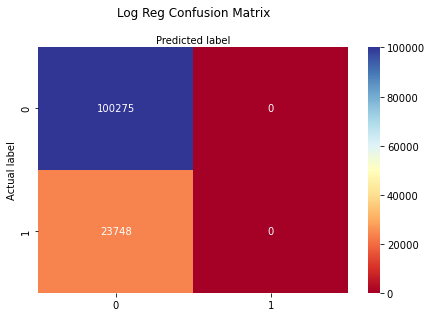

In [220]:
print("Trained with no reduction in dimensionality and variance")
log_reg_classification(x_train, x_test, y_train_class, y_test_class)

# Testing Decision Tree Classifier

Trained with no reduction in dimensionality and variance
Classification Accuracy with 25 cols: 0.7221321851592043


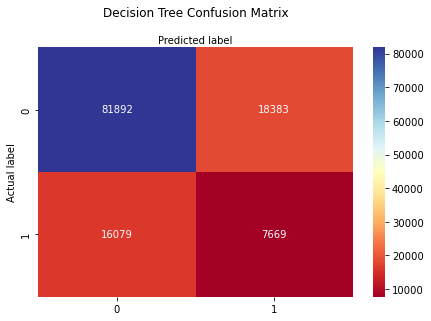

F1 Score: 0.30799196787148597


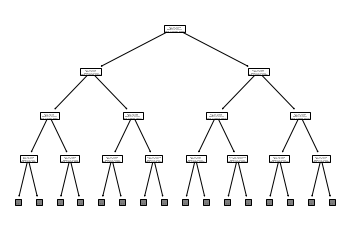

In [221]:
print("Trained with no reduction in dimensionality and variance")
decision_tree = decision_tree_classification(x_train, x_test, y_train_class, y_test_class, plot_tree=True, depth = 3)


# Testing Gradient Boosted Tree Classifier

Trained with no reduction in dimensionality and variance
Classification Accuracy with 25 cols: 0.818404650750264
F1 Score: 0.20456311365402272


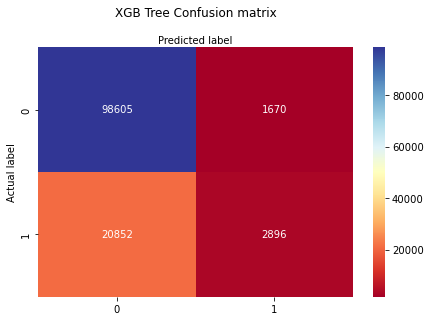

In [219]:
print("Trained with no reduction in dimensionality and variance")
gradient_boosted_classification(x_train, x_test, y_train_class, y_test_class)


# Testing Linear Regressor

MSE with 5 cols: 1988.671378323341
MAE with 5 cols: 20.25305903060179
r^2 with 5 cols: 0.01328202344556706


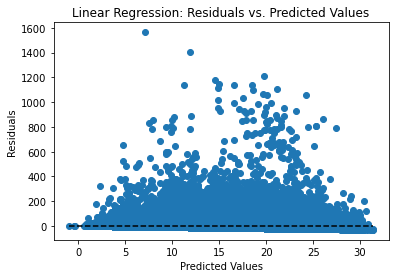

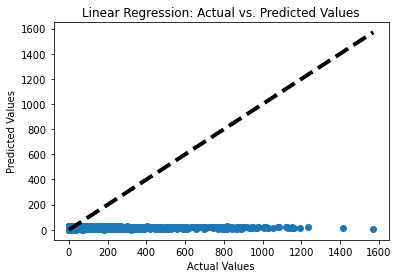

MSE with 10 cols: 1945.133904299823
MAE with 10 cols: 19.844225316085524
r^2 with 10 cols: 0.03488398782290736


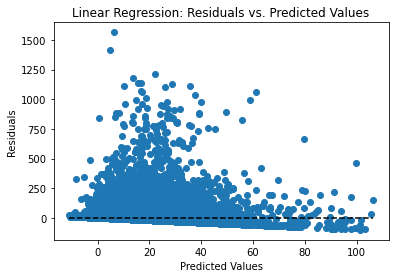

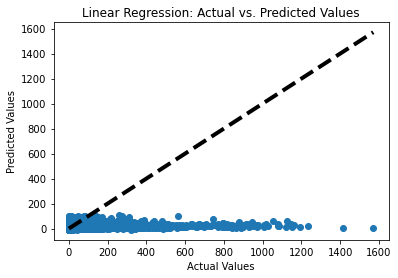

MSE with 15 cols: 1936.7694711599402
MAE with 15 cols: 19.754831523909345
r^2 with 15 cols: 0.0390341639821119


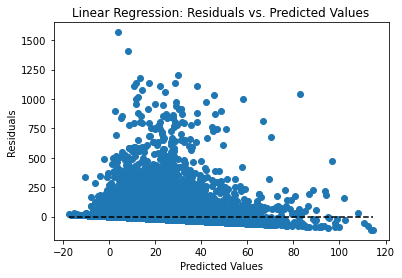

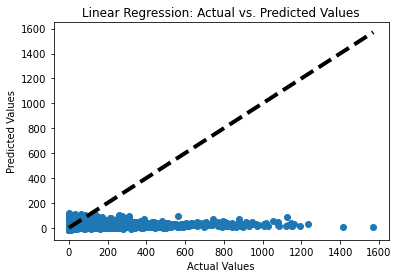

MSE with 20 cols: 1935.9270493884706
MAE with 20 cols: 19.745977656011895
r^2 with 20 cols: 0.03945214792597018


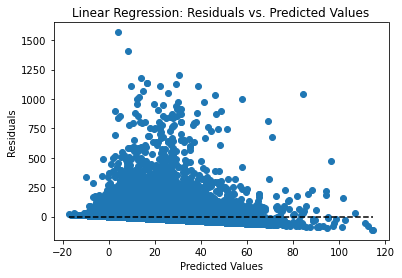

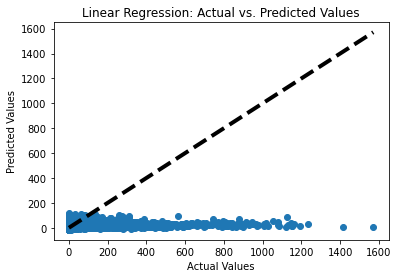

MSE with 25 cols: 1935.7945661733534
MAE with 25 cols: 19.749346371156033
r^2 with 25 cols: 0.03951788204945228


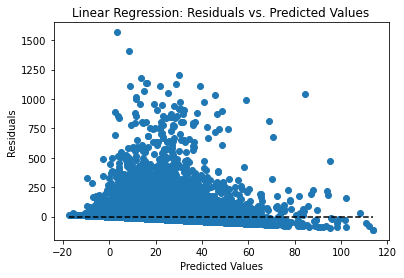

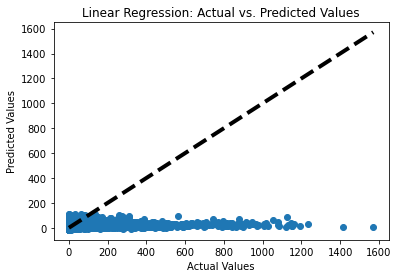

MSE:  1988.671378323341
R^2: 0.01328202344556706


In [228]:
mse = []
r_squared = []
components = []
mae = []

for i in range(5, 28, 5):
    components.append(i)
    
    k = i
    cut_x_train = pca_transformed.get(k)[0]
    cut_x_test = pca_transformed.get(k)[1]
    
    vals = linear_regression(cut_x_train, cut_x_test, y_train_regres, y_test_regres)
    mse.append(vals[1])
    r_squared.append(vals[0])
    mae.append(vals[2])
    
for v in mse[::5]:
    print("MSE:  {}".format(v))
    
for v in r_squared[::5]:
    print("R^2: {}".format(v))

Trained with no reduction in dimensionality and variance
MSE with 25 cols: 1935.7941820758251
MAE with 25 cols: 19.75138387214098
r^2 with 25 cols: 0.039518072626910206


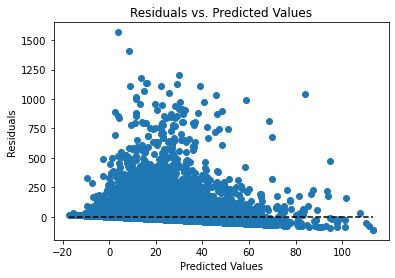

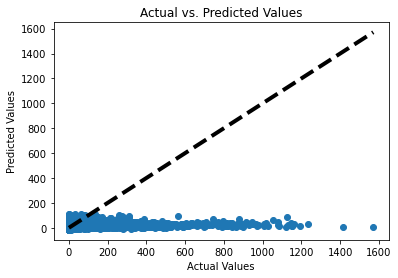

(0.039518072626910206, 1935.7941820758251, 19.75138387214098)

In [224]:
print("Trained with no reduction in dimensionality and variance")
linear_regression(x_train, x_test, y_train_regres, y_test_regres)


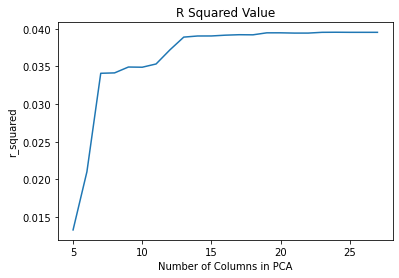

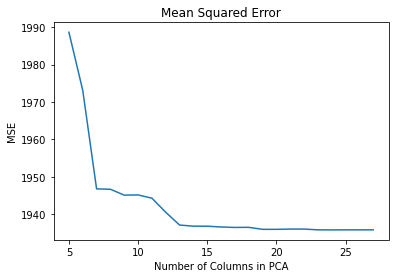

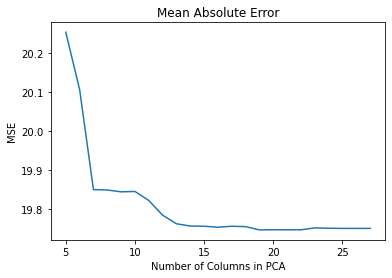

In [196]:
fig = plt.figure()
plt.plot(components, r_squared)
plt.title("R Squared Value")
plt.xlabel('Number of Columns in PCA')
plt.ylabel('r_squared')
plt.show()

fig = plt.figure()
plt.plot(components, mse)
plt.title("Mean Squared Error")
plt.xlabel('Number of Columns in PCA')
plt.ylabel('MSE')
plt.show()

fig = plt.figure()
plt.plot(components, mae)
plt.title("Mean Absolute Error")
plt.xlabel('Number of Columns in PCA')
plt.ylabel('MSE')
plt.show()

# Testing Gradient Boosted Tree Regressor

Trained with no reduction in dimensionality and variance
MSE with 25 cols: 1892.326504442805
MAE with 25 cols: 18.855751844002484
r^2 with 25 cols: 0.06108540616782698


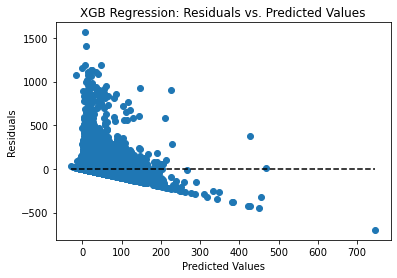

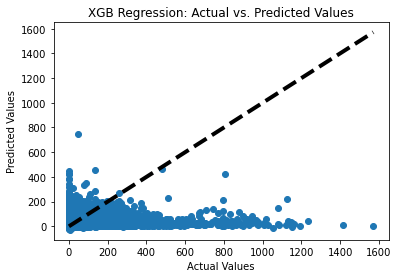

(0.06108540616782698, 1892.326504442805, 18.855751844002484)

In [229]:
print("Trained with no reduction in dimensionality and variance")
gradient_boosted_regression(x_train, x_test, y_train_regres, y_test_regres)


# Importance Rankings for Classification

With the models built, we'll look at the feature importances of each model to provide some possible insights on what predictors are closley related-possible causally related-with  delay time. We'll look at the feature importances for teh deicion tree classifier, gain and weight graphs for the XGB classifier & regressor, and coefficients of the linear regressor to determine feature importances.   

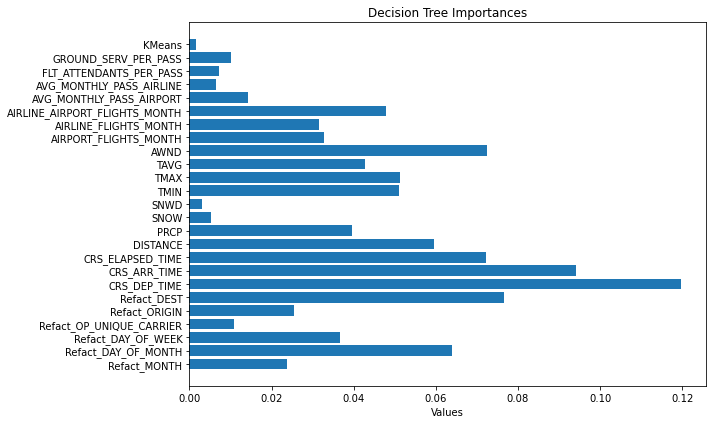

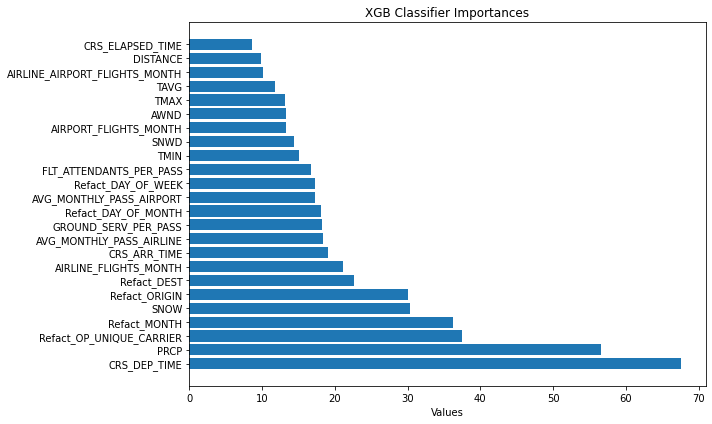

In [198]:

#XGB Importances
for item in classifiers.items():
    name = item[0] + ' Importances'

    model = item[1]
    df = pd.DataFrame()
    if item[0] == 'Decision Tree':
        
        df = [x_train.columns, model.feature_importances_]
        df = pd.DataFrame(df)
        df = df.transpose()
        df = df.set_index(df.iloc[:, 0])
        df = df.drop([0], axis = 1)

        plt.figure(figsize=(10,6))  # Optional: Adjust the figure size if needed
        plt.barh(df.index, df[1])
        plt.xlabel('Values')
        plt.title(name)
        plt.tight_layout()  # This can help ensure everything fits without overlapping
        plt.show()

    elif item[0] == 'Log Reg':
        continue
    else:
        dic = model.get_booster().get_score(importance_type='gain')
        df = pd.DataFrame(list(dic.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
        df = df.set_index('Feature')

        plt.figure(figsize=(10,6))  # Optional: Adjust the figure size if needed
        plt.barh(df.index, df['Importance'])
        plt.xlabel('Values')
        plt.title(name)
        plt.tight_layout()  # This can help ensure everything fits without overlapping
        plt.show()


[ 9.21205105e-01  8.98021642e-01  8.76174901e-01  6.25390003e-01
  4.40515461e-01  8.56682175e-01  7.86302922e-03  3.21380349e-03
  4.17648769e-02 -4.21569819e-03  1.23255133e+01  6.87663689e+00
  1.22176856e+00  7.60925419e-02  2.68737031e-02 -5.64585172e-02
  2.70396315e-01  2.22043361e-06 -5.14546837e-06 -2.16172834e-04
  2.00446394e-07  2.83989571e-07 -3.58323355e+03 -8.68892761e+03
  1.08971708e+00]


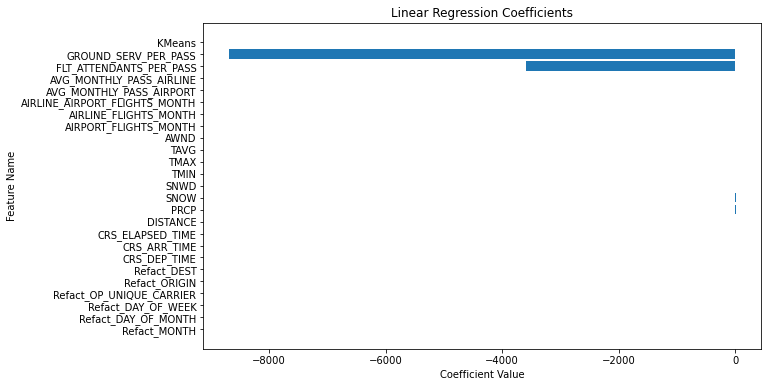

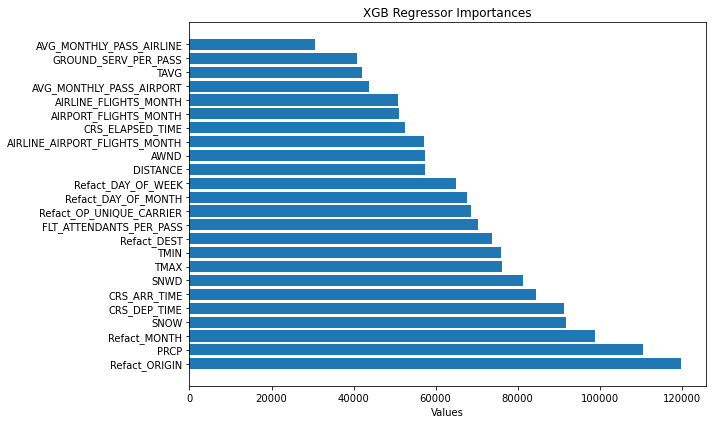

In [199]:

#XGB Importances
for item in regressors.items():
    name = item[0] + ' Importances'

    model = item[1]
    df = pd.DataFrame()
    if item[0] == 'Lin Reg':
        
        coefs = model.coef_
       
        plt.figure(figsize=(10,6))
        print(coefs)

        plt.barh(list(x_train.columns), coefs)
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature Name')
        plt.title('Linear Regression Coefficients')
        plt.show()

    else:
        dic = model.get_booster().get_score(importance_type='gain')
        df = pd.DataFrame(list(dic.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
        df = df.set_index('Feature')

        plt.figure(figsize=(10,6))  # Optional: Adjust the figure size if needed
        plt.barh(df.index, df['Importance'])
        plt.xlabel('Values')
        plt.title(name)
        plt.tight_layout()  # This can help ensure everything fits without overlapping
        plt.show()


# Performance Analysis
Overall the gradient boosted classifiers and regressors outperformed teh other models, except the linear logistic classifier trained on the dataset transformed with PCA had a higher f1 score. 